<a href="https://colab.research.google.com/github/Ntambe25/ECGR-8119-Applied-AI/blob/main/ECGR8119_FinalProject_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECGR 8119 - Applied AI Final Project


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from scipy.optimize import minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the data from CSV
data_path = '/content/drive/MyDrive/ECGR8119_FinalProject/preprocessed_data.csv'

# Load dataset
loaded_data = pd.read_csv(data_path)

In [ ]:
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   instance_events_type             405894 non-null  int64  
 1   scheduling_class                 405894 non-null  int64  
 2   collection_type                  405894 non-null  int64  
 3   priority                         405894 non-null  int64  
 4   assigned_memory                  405894 non-null  float64
 5   page_cache_memory                405894 non-null  float64
 6   cycles_per_instruction           405894 non-null  float64
 7   memory_accesses_per_instruction  405894 non-null  float64
 8   sample_rate                      405894 non-null  float64
 9   cluster                          405894 non-null  int64  
 10  event                            405894 non-null  int64  
 11  failed                           405894 non-null  int64  
 12  to

In [ ]:
# Function to retrain Random Forest with emphasis on resource request columns
def retrain_random_forest(data, resource_columns=['resource_request_memory', 'resource_request_cpus']):
    # Extract features (X) and target variable (y)
    X = data.drop(columns=['total_time'])  # Drop the target column 'total_time'
    y = data['total_time']  # Target variable

    # Scaling the resource request columns to emphasize them
    scaler = StandardScaler()
    X_scaled = X.copy()

    # Scale resource request columns to a higher range
    X_scaled[resource_columns] = scaler.fit_transform(X[resource_columns]) * 1000  # Amplify the effect of these columns

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Training R^2 score: {train_score:.4f}")
    print(f"Testing R^2 score: {test_score:.4f}")

    return model, scaler

# Example usage
model, scaler = retrain_random_forest(loaded_data)  # Replace 'loaded_data' with your dataset

# Save the retrained model for later use
import joblib
joblib.dump(model, '/content/drive/MyDrive/ECGR8119_FinalProject/retrained_random_forest_model.pkl')


Training R^2 score: 0.9999
Testing R^2 score: 0.9990


['/content/drive/MyDrive/ECGR8119_FinalProject/retrained_random_forest_model.pkl']

In [ ]:
from scipy.optimize import minimize
import numpy as np
import joblib
import pandas as pd

# Function to load the trained model
def load_trained_model(model_path):
    return joblib.load(model_path)

# Optimization objective function
def optimization_function(params, model, X_fixed, threshold):
    # Update the memory and CPU allocations (optimized values)
    X_fixed.loc[:, 'maximum_usage_memory'] = params[0]
    X_fixed.loc[:, 'maximum_usage_cpus'] = params[1]

    # Predict total_time
    predicted_time = model.predict(X_fixed)

    # Define penalty for exceeding the threshold
    penalty = 10 * (predicted_time[0] - threshold) ** 2 if predicted_time[0] > threshold else 0

    # Minimize resource usage + penalty
    return params[0] + params[1] + penalty

# Main function to optimize resources
def optimize_resources(data, model_path, task_index, threshold=100000):
    # Load the pre-trained Random Forest model
    model = load_trained_model(model_path)

    # Prepare the input data (ensure features match the trained model)
    X = data.drop(columns=['total_time'])  # Drop the target column
    trained_feature_columns = model.feature_names_in_
    X = X[trained_feature_columns]

    # Select the specific task (row) for optimization
    task = X.iloc[task_index:task_index + 1]

    # Use resource_request_memory and resource_request_cpus as the base metrics for optimization
    requested_memory = task['resource_request_memory'].values[0]
    requested_cpus = task['resource_request_cpus'].values[0]

    # Predict initial total_time based on resource requests
    initial_predicted_time = model.predict(task)[0]

    # Initial guess for optimization (use resource request values)
    initial_guess = [requested_memory, requested_cpus]

    # Define bounds for memory and CPUs
    bounds = [
        (0.000001, 0.3),  # Memory bounds
        (0.000001, 0.6)   # CPU bounds
    ]

    # Perform optimization
    result = minimize(
        optimization_function,
        initial_guess,
        args=(model, task.copy(), threshold),
        bounds=bounds,
        method='L-BFGS-B'
    )

    optimized_memory = task['maximum_usage_memory'].values[0]
    optimized_cpus = task['maximum_usage_cpus'].values[0]

    # Predict total_time after optimization with the maximum usage values
    optimized_predicted_time = model.predict(task)[0]

    # Output results
    print(f"Original Resource Requests and Predicted Time:")
    print(f"Memory: {requested_memory:.6f} GB")
    print(f"CPUs: {requested_cpus:.6f}")

    print(f"Optimized Resource Allocation and Predicted Time:")
    print(f"Memory: {optimized_memory:.6f} GB")
    print(f"CPUs: {optimized_cpus:.6f}")
    print(f"Optimized Predicted Time: {optimized_predicted_time:.2f} micro-seconds\n")

# Example usage
# Assuming 'loaded_data' is your dataset loaded as a DataFrame
# and model_path is the path to your saved Random Forest model
model_path = '/content/drive/MyDrive/ECGR8119_FinalProject/retrained_random_forest_model.pkl'
task_index = 11  # Change this to select a different task row
optimize_resources(loaded_data, model_path, task_index, threshold=100000)

Original Resource Requests and Predicted Time:
Memory: 0.010422 GB
CPUs: 0.041199
Optimized Resource Allocation and Predicted Time:
Memory: 0.000070 GB
CPUs: 0.013275
Optimized Predicted Time: 3000000.00 micro-seconds



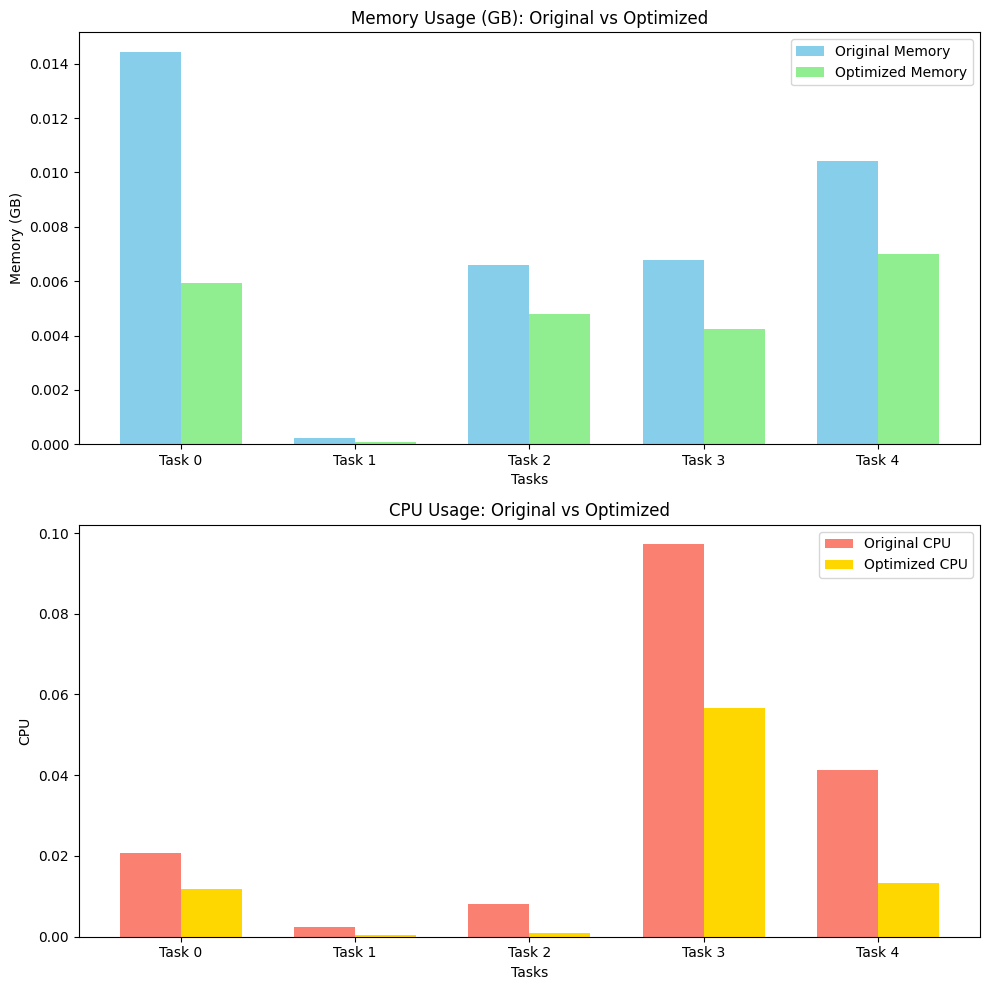

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the tasks
tasks = ['Task 0', 'Task 1', 'Task 2', 'Task 3', 'Task 4']

# Original and Optimized Resource Requests
memory_original = [0.014435, 0.000232, 0.006613, 0.006767, 0.010422]  # in GB
cpu_original = [0.020660, 0.002449, 0.008102, 0.097168, 0.041199]

memory_optimized = [0.005936, 0.000076, 0.00479, 0.004242, 0.0070]  # in GB
cpu_optimized = [0.011902, 0.000415, 0.000818, 0.056611, 0.013275]

# Create subplots for Memory and CPU comparisons
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Memory comparison
x = np.arange(len(tasks))
width = 0.35  # width of the bars

axs[0].bar(x - width/2, memory_original, width, label='Original Memory', color='skyblue')
axs[0].bar(x + width/2, memory_optimized, width, label='Optimized Memory', color='lightgreen')

axs[0].set_title('Memory Usage (GB): Original vs Optimized')
axs[0].set_xlabel('Tasks')
axs[0].set_ylabel('Memory (GB)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(tasks)
axs[0].legend()

# Plot CPU comparison
axs[1].bar(x - width/2, cpu_original, width, label='Original CPU', color='salmon')
axs[1].bar(x + width/2, cpu_optimized, width, label='Optimized CPU', color='gold')

axs[1].set_title('CPU Usage: Original vs Optimized')
axs[1].set_xlabel('Tasks')
axs[1].set_ylabel('CPU')
axs[1].set_xticks(x)
axs[1].set_xticklabels(tasks)
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()
